In [18]:
#Convert address to coordinates

address = input("Enter a street address:")

#Use geocoding API to convert address to coordinates

import geocoder
import os

#Set environment with Goodle API key
#os.environ["GOOGLE_API_KEY"] = "#API key needs to be hidden in github

g = geocoder.google('Mountain View, CA', key='')

#Extract latitude and longitude
lat = g.osm['x']
long = g.osm['y']

#Use geopunt.be API to retrieve latitude and longitude
#https://loc.geopunt.be
#GET v2/Location?q={q}&latlon={latlon}&xy={xy}&capakey={capakey}&poi={poi}&c={c}

<[OK] Google - Geocode [Mountain View, CA, USA]>

In [ ]:
#Get DSM file
#http://www.geopunt.be/download?container=dhm-vlaanderen-ii-dsm-raster-1m&title=Digitaal%20Hoogtemodel%20Vlaanderen%20II,%20DSM,%20raster,%201m
#Get DTM file
#http://www.geopunt.be/download?container=dhm-vlaanderen-ii-dtm-raster-1m&title=Digitaal%20Hoogtemodel%20Vlaanderen%20II,%20DTM,%20raster,%201m

#Try using geopunt webservice to retrieve DSM and DTM files


In [ ]:
#load shape file with Geopandas


#Also possible to subset shape file to reduce memory requirements



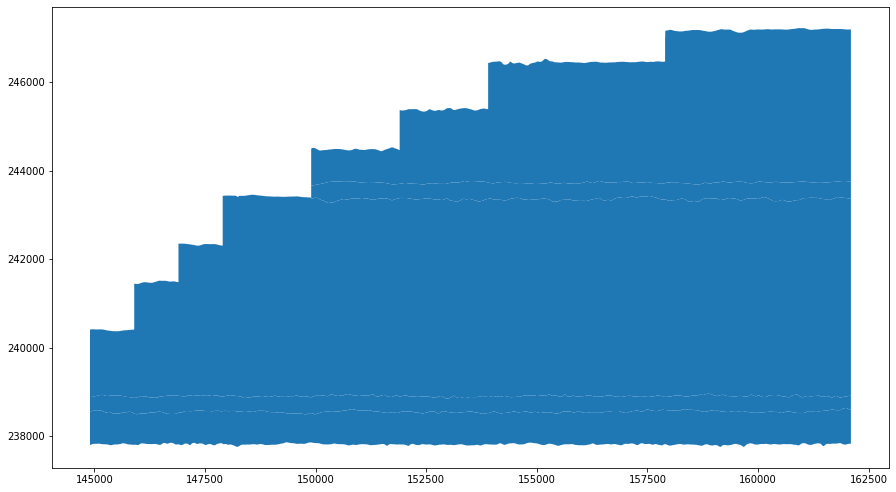

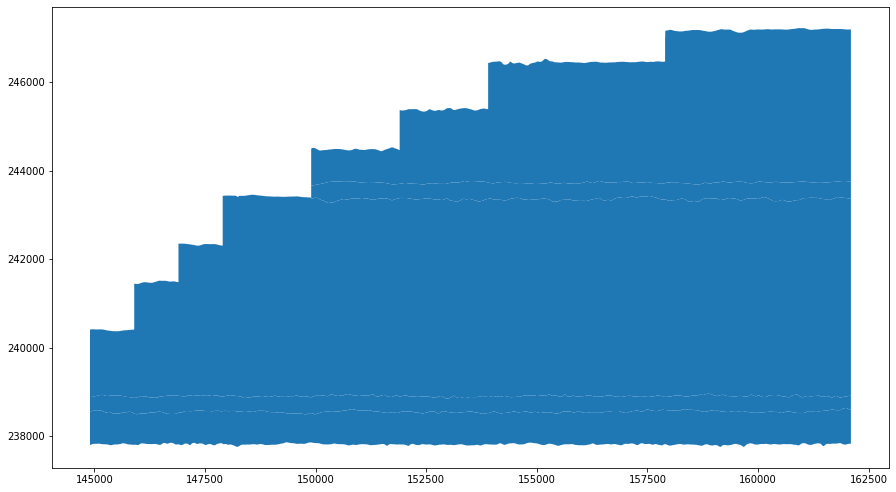

In [5]:
#opening and ploting DSM and DTM shape data
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

dsm_shp = "/home/becode/dr-robin/theano/3D_houses data/DSM/DHMVII_vdc_k01.shp"
dtm_shp = "/home/becode/dr-robin/theano/3D_houses data/DTM/DHMVII_vdc_k01.shp"

dsm_map = gpd.read_file(dsm_shp)
fig, ax = plt.subplots(figsize = (15,15))
dsm_map.plot(ax=ax)

dtm_map = gpd.read_file(dtm_shp)
fig, ax = plt.subplots(figsize = (15,15))
dtm_map.plot(ax=ax)



In [6]:
#Opening a geotiff file

import os
import rasterio as rio
import earthpy as et

geotifffile = '/home/becode/dr-robin/theano/3D_houses data/DSM/DHMVIIDSMRAS1m_k01.tif'
#open geotiff file
with rio.open(geotifffile) as lidar_dsm:
    lidar_dsm.bounds

In [7]:
geotiff_dsm = '/home/becode/dr-robin/theano/3D_houses data/DSM/DHMVIIDSMRAS1m_k01.tif'
geotiff_dtm = '/home/becode/dr-robin/theano/3D_houses data/DTM/DHMVIIDTMRAS1m_k01.tif'

lidar_dsm = rio.open(geotiff_dsm)
lidar_dtm = rio.open(geotiff_dtm)

# View generate metadata associated with the raster file
print(lidar_dsm.meta)

# What is the spatial resolution?
print(lidar_dsm.res)

# View image structure
print(lidar_dsm.tags(ns='IMAGE_STRUCTURE'))
lidar_dsm_mask = lidar_dsm.dataset_mask()

#View data mask =0 are nodata values whereas = 255 are usable data values.
print(lidar_dsm_mask)

print(lidar_dsm.crs)

print(lidar_dsm.bounds)

#Check is dsm and dtm file have the same spatial extent
lidar_dsm.bounds == lidar_dtm.bounds

#Check if dsm and dtm file have the same resolution
lidar_dsm.res == lidar_dtm.res

#Access extra meta data by converting EPSG to proj4 code
lidar_dsm.crs.data

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 17000, 'height': 9000, 'count': 1, 'crs': CRS.from_epsg(31370), 'transform': Affine(1.0, 0.0, 145000.0,
       0.0, -1.0, 247000.0)}
(1.0, 1.0)
{'COMPRESSION': 'DEFLATE', 'INTERLEAVE': 'BAND'}
[[  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
EPSG:31370
BoundingBox(left=145000.0, bottom=238000.0, right=162000.0, top=247000.0)


{'init': 'epsg:31370'}

(9000, 17000)


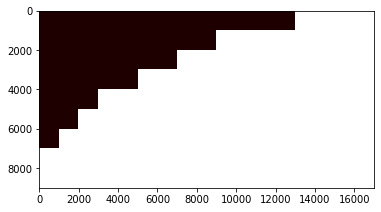

In [65]:
import rasterio as rio
src = rio.open('/home/becode/dr-robin/theano/3D_houses data/DSM/DHMVIIDSMRAS1m_k01.tif')
src = rio.open('/home/becode/dr-robin/theano/3D_houses data/DTM/DHMVIIDTMRAS1m_k01.tif')
src.name
src.mode
src.closed
array = src.read(1)
print(array.shape)
from matplotlib import pyplot
pyplot.imshow(array, cmap='pink')

pyplot.show()  

In [66]:
#try gdal

from osgeo import gdal
import matplotlib.pyplot as plt

src = rio.open('/home/becode/dr-robin/theano/3D_houses data/DSM/DHMVIIDSMRAS1m_k01.tif')

ds = gdal.Open(src).ReadAsArray()

im = plt.imshow(ds)


ModuleNotFoundError: No module named 'osgeo'

In [69]:
import rasterio
from matplotlib import pyplot
src = rio.open('/home/becode/dr-robin/theano/3D_houses data/DSM/DHMVIIDSMRAS1m_k01.tif')
pyplot.imshow(src.read(1), cmap='pink')
pyplot.show()

SyntaxError: positional argument follows keyword argument (<ipython-input-69-42b5f116b4bb>, line 4)

In [12]:
import rasterio

file = '/home/becode/Downloads/DHMVIIDTMRAS1m_k01.tif'
dataset = rasterio.open(file)

In [1]:
#dir(rasterio)

In [14]:
dataset.width
dataset.height
#Every pixel in tif file is contained within a spatial bounding box (in metres) that is mapped to a region on the earth's surface
dataset.bounds
#geospatial transform that maps pixel locations (row, col coordinates) to spatial position (x, y)
dataset.transform
#gets the top left corner
dataset.transform * (0,0)

#get the bottom right corner
dataset.transform * (dataset.width, dataset.height)

#coordinate values are relative to the origin of the dataset's coordinate reference system (CRS)
dataset.crs

#access raster band by band's index number
dataset.indexes
band1 = dataset.read(1)



In [11]:
#access values inarray by row and column index
band1[dataset.height // 2, dataset.width // 2]

array([[-9.999e+03, -9.999e+03, -9.999e+03, ...,  1.275e+01,  1.279e+01,
         1.280e+01],
       [-9.999e+03, -9.999e+03, -9.999e+03, ...,  1.280e+01,  1.281e+01,
         1.284e+01],
       [-9.999e+03, -9.999e+03, -9.999e+03, ...,  1.284e+01,  1.283e+01,
         1.288e+01],
       ...,
       [ 4.520e+00,  4.550e+00,  4.570e+00, ...,  1.680e+01,  1.693e+01,
         1.690e+01],
       [ 4.490e+00,  4.570e+00,  4.580e+00, ...,  1.691e+01,  1.691e+01,
         1.693e+01],
       [ 4.480e+00,  4.550e+00,  4.570e+00, ...,  1.686e+01,  1.688e+01,
         1.690e+01]], dtype=float32)

In [17]:
#get array indices for points in the georeferenced space using index
#for example get the value for the pixel 100km east and 50km south
x, y = (dataset.bounds.left + 1000, dataset.bounds.top - 1000)
row, col = dataset.index(x, y)

print(band1[row, col])

-9999.0


In [18]:
#get the spatial coordinates of a pixel
#coordinates of center of the image
dataset.xy(dataset.height // 2, dataset.width // 2)

(153500.5, 242499.5)

In [20]:
from shapely.geometry import Polygon
Polygon([[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]]).minimum_clearance

AttributeError: 'Polygon' object has no attribute 'minimum_clearance'

In [2]:
#Potential to convert Geotiffs to Cloud Optimized Geotiffs
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Specify the path for Landsat TIF on AWS
fp = 'http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF'

# See the profile
with rasterio.open(fp) as src:
    print(src.profile)
    

ModuleNotFoundError: No module named 'rasterio'

In [4]:
#Promising tool for visualisation LIDAR point clouds
import numpy 
import pptk 
P = numpy.random.rand(100, 3) 
v = pptk.viewer(P) 
v.set(point_size=0.01)

KeyboardInterrupt: 